In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense,Conv2D
from keras.layers import LeakyReLU,Flatten
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

In [35]:
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()

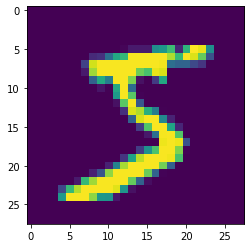

In [9]:
plt.imshow(train_images[0])

In [14]:
print(train_images.shape)

(60000, 28, 28)


In [15]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)

In [16]:
train_images.shape

(60000, 28, 28, 1)

In [17]:
# normalizing the data
train_images=(train_images-127.5)/127.5

In [18]:
Buffer_size=train_images.shape[0]
Batch_size=100
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_size).batch(Batch_size)

In [30]:
for ele in train_dataset:
    print(ele.numpy().shape)

(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 

### Discriminator model

In [36]:
def make_descriminator_model():
    model=Sequential()
    model.add(Conv2D(7,(3,3),padding="same",input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(LeakyReLU())
    model.add(Dense(50,activation="relu"))
    model.add(Dense(1))
    return model

In [38]:
model_discriminator=make_descriminator_model()

In [40]:
model_discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 7)         70        
_________________________________________________________________
flatten_1 (Flatten)          (None, 5488)              0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5488)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                274450    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 274,571
Trainable params: 274,571
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_discriminator(np.random.rand(1,28,28,1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.44041613]], dtype=float32)>

In [44]:
discriminator_optimizer=tf.optimizers.Adam(1e-3)

In [49]:
def get_discriminator_loss(real_predictions,fake_predictions):
    real_predictions=tf.sigmoid(real_predictions)
    fake_predictions=tf.sigmoid(fake_predictions)
    real_loss=tf.losses.binary_crossentropy(tf.ones_like(real_predictions),real_predictions)
    fake_loss=tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
    return real_loss + fake_loss

### Generator

In [54]:
def make_generator_model():
    model=Sequential()
    model.add(Dense(7*7*256,input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128,(3,3),padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1,(3,3),strides=(2,2),padding="same"))
    return model

In [55]:
generator=make_generator_model()

In [56]:
generator_optimizer=tf.optimizers.Adam(1e-4)

In [58]:
def get_generator_loss(fake_predictions):
    fake_predictions=tf.sigmoid(fake_predictions)
    fake_loss=tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
    return fake_loss

### Training

In [59]:
def train(dataset,epochs):
    for _ in range(epochs):
        for images in dataset:
            images=tf.cast(images,tf.dtypes.float32)
            train_step(images)

In [62]:
def train_step(images):
    fake_image_noise=np.random.randn(Batch_size,100).astype("float32")
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images=generator(fake_image_noise)
        real_output=model_discriminator(images)
        fake_output=model_discriminator(generated_images)
        
        gen_loss=get_generator_loss(fake_output)
        disc_loss=get_discriminator_loss(real_output,fake_output)
        
        gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
        gradients_of_discriminator=disc_tape.gradient(disc_loss,model_discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,model_discriminator.trainable_variables))
        
        print("generator_loss",np.mean(gen_loss))
        print("discriminator_loss",np.mean(disc_loss))

In [63]:
train(train_dataset,2)

generator_loss 0.6913166
discriminator_loss 1.4225808
generator_loss 0.67116606
discriminator_loss 0.7619193
generator_loss 0.64138573
discriminator_loss 0.75280714
generator_loss 0.6005553
discriminator_loss 0.7963188
generator_loss 0.5603382
discriminator_loss 0.84748006
generator_loss 0.50201315
discriminator_loss 0.9313218
generator_loss 0.44367453
discriminator_loss 1.029303
generator_loss 0.38668397
discriminator_loss 1.1407582
generator_loss 0.33040738
discriminator_loss 1.272347
generator_loss 0.2674469
discriminator_loss 1.4551648
generator_loss 0.21710934
discriminator_loss 1.6421851
generator_loss 0.17237794
discriminator_loss 1.8518616
generator_loss 0.13344792
discriminator_loss 2.0913868
generator_loss 0.097499825
discriminator_loss 2.3897762
generator_loss 0.06978269
discriminator_loss 2.7170417
generator_loss 0.051764704
discriminator_loss 3.0079012
generator_loss 0.037245587
discriminator_loss 3.3334098
generator_loss 0.025740098
discriminator_loss 3.7095327
generator_

generator_loss 4.8461206e-05
discriminator_loss 10.047426
generator_loss 4.541651e-05
discriminator_loss 10.148068
generator_loss 4.5112436e-05
discriminator_loss 10.133814
generator_loss 4.7033038e-05
discriminator_loss 10.093943
generator_loss 4.733346e-05
discriminator_loss 10.085813
generator_loss 4.4342334e-05
discriminator_loss 10.152297
generator_loss 4.6023295e-05
discriminator_loss 10.132061
generator_loss 4.8655605e-05
discriminator_loss 10.078285
generator_loss 4.887027e-05
discriminator_loss 10.1205015
generator_loss 5.2863503e-05
discriminator_loss 10.011089
generator_loss 4.348879e-05
discriminator_loss 10.183227
generator_loss 4.247784e-05
discriminator_loss 10.200388
generator_loss 4.7968846e-05
discriminator_loss 10.058833
generator_loss 4.577419e-05
discriminator_loss 10.144687
generator_loss 4.7245263e-05
discriminator_loss 10.097937
generator_loss 4.521628e-05
discriminator_loss 10.18165
generator_loss 4.8266513e-05
discriminator_loss 10.09877
generator_loss 4.13548

generator_loss 3.541429e-05
discriminator_loss 10.365736
generator_loss 3.704997e-05
discriminator_loss 10.390467
generator_loss 4.0832656e-05
discriminator_loss 10.261152
generator_loss 3.658873e-05
discriminator_loss 10.445176
generator_loss 3.384308e-05
discriminator_loss 10.439242
generator_loss 3.3211232e-05
discriminator_loss 10.456452
generator_loss 3.3974236e-05
discriminator_loss 10.476875
generator_loss 3.3169566e-05
discriminator_loss 10.505676
generator_loss 3.112977e-05
discriminator_loss 10.540354
generator_loss 3.7406404e-05
discriminator_loss 10.347882
generator_loss 3.4584595e-05
discriminator_loss 10.42142
generator_loss 3.3438915e-05
discriminator_loss 10.435899
generator_loss 3.374771e-05
discriminator_loss 10.447405
generator_loss 3.2678377e-05
discriminator_loss 10.5195675
generator_loss 3.3041968e-05
discriminator_loss 10.4664345
generator_loss 3.087708e-05
discriminator_loss 10.596766
generator_loss 3.386814e-05
discriminator_loss 10.451752
generator_loss 3.3481

generator_loss 2.490921e-05
discriminator_loss 10.777649
generator_loss 2.3452438e-05
discriminator_loss 10.849981
generator_loss 2.5326475e-05
discriminator_loss 10.793118
generator_loss 2.3411889e-05
discriminator_loss 10.834912
generator_loss 2.6575803e-05
discriminator_loss 10.722439
generator_loss 2.5854537e-05
discriminator_loss 10.705562
generator_loss 2.4987914e-05
discriminator_loss 10.77593
generator_loss 2.6759415e-05
discriminator_loss 10.707179
generator_loss 2.7734603e-05
discriminator_loss 10.698661
generator_loss 2.3628852e-05
discriminator_loss 10.80177
generator_loss 2.4147463e-05
discriminator_loss 10.851355
generator_loss 2.5535055e-05
discriminator_loss 10.721157
generator_loss 2.5037969e-05
discriminator_loss 10.802764
generator_loss 2.5728275e-05
discriminator_loss 10.764971
generator_loss 2.2790755e-05
discriminator_loss 10.803937
generator_loss 2.7802535e-05
discriminator_loss 10.666804
generator_loss 2.5616127e-05
discriminator_loss 10.727656
generator_loss 2.

generator_loss 2.2744278e-05
discriminator_loss 10.829694
generator_loss 1.7553786e-05
discriminator_loss 11.1091175
generator_loss 1.6995877e-05
discriminator_loss 11.157197
generator_loss 1.7866112e-05
discriminator_loss 11.100674
generator_loss 1.889255e-05
discriminator_loss 11.049094
generator_loss 1.8490779e-05
discriminator_loss 11.05457
generator_loss 1.8321507e-05
discriminator_loss 11.083966
generator_loss 1.959589e-05
discriminator_loss 11.022883
generator_loss 2.0282558e-05
discriminator_loss 10.974778
generator_loss 1.6880223e-05
discriminator_loss 11.136757
generator_loss 1.6896907e-05
discriminator_loss 11.1302805
generator_loss 2.0660445e-05
discriminator_loss 10.972521
generator_loss 1.7380928e-05
discriminator_loss 11.142706
generator_loss 1.8742332e-05
discriminator_loss 11.0817795
generator_loss 1.8769746e-05
discriminator_loss 11.040532
generator_loss 1.9229918e-05
discriminator_loss 11.02703
generator_loss 1.9552965e-05
discriminator_loss 10.99176
generator_loss 1

generator_loss 1.5058709e-05
discriminator_loss 11.3371525
generator_loss 1.4913242e-05
discriminator_loss 11.306247
generator_loss 1.6142341e-05
discriminator_loss 11.251261
generator_loss 1.280558e-05
discriminator_loss 11.433976
generator_loss 1.49716625e-05
discriminator_loss 11.340133
generator_loss 1.3477929e-05
discriminator_loss 11.399476
generator_loss 1.4296917e-05
discriminator_loss 11.324865
generator_loss 1.4234928e-05
discriminator_loss 11.3522835
generator_loss 1.3595944e-05
discriminator_loss 11.351688
generator_loss 1.4048958e-05
discriminator_loss 11.385406
generator_loss 1.467362e-05
discriminator_loss 11.304853
generator_loss 1.49347e-05
discriminator_loss 11.298946
generator_loss 1.428379e-05
discriminator_loss 11.306052
generator_loss 1.3238315e-05
discriminator_loss 11.393633
generator_loss 1.3710396e-05
discriminator_loss 11.402088
generator_loss 1.4521033e-05
discriminator_loss 11.327339
generator_loss 1.2710205e-05
discriminator_loss 11.447644
generator_loss 1

generator_loss 1.0613289e-05
discriminator_loss 11.676352
generator_loss 1.1211726e-05
discriminator_loss 11.621945
generator_loss 1.1751746e-05
discriminator_loss 11.521423
generator_loss 1.0963768e-05
discriminator_loss 11.600221
generator_loss 1.0472611e-05
discriminator_loss 11.6339855
generator_loss 1.1365516e-05
discriminator_loss 11.609812
generator_loss 1.0578721e-05
discriminator_loss 11.681027
generator_loss 1.0279494e-05
discriminator_loss 11.671802
generator_loss 1.074799e-05
discriminator_loss 11.626259
generator_loss 1.128324e-05
discriminator_loss 11.533357
generator_loss 1.1547909e-05
discriminator_loss 11.582911
generator_loss 1.06275975e-05
discriminator_loss 11.65994
generator_loss 1.1040065e-05
discriminator_loss 11.634285
generator_loss 1.1178344e-05
discriminator_loss 11.566912
generator_loss 1.1321399e-05
discriminator_loss 11.578625
generator_loss 9.809811e-06
discriminator_loss 11.749416
generator_loss 9.752581e-06
discriminator_loss 11.73719
generator_loss 1.1

generator_loss 7.771298e-06
discriminator_loss 11.949497
generator_loss 8.213571e-06
discriminator_loss 11.927365
generator_loss 9.6250305e-06
discriminator_loss 11.777414
generator_loss 9.049235e-06
discriminator_loss 11.7647915
generator_loss 8.854923e-06
discriminator_loss 11.796612
generator_loss 8.740477e-06
discriminator_loss 11.81618
generator_loss 9.660786e-06
discriminator_loss 11.715877
generator_loss 8.850152e-06
discriminator_loss 11.788052
generator_loss 8.386421e-06
discriminator_loss 11.826686
generator_loss 8.832273e-06
discriminator_loss 11.819602
generator_loss 8.812005e-06
discriminator_loss 11.83112
generator_loss 8.628422e-06
discriminator_loss 11.812442
generator_loss 9.007514e-06
discriminator_loss 11.800023
generator_loss 8.778628e-06
discriminator_loss 11.818607
generator_loss 7.9536885e-06
discriminator_loss 11.921837
generator_loss 8.601005e-06
discriminator_loss 11.871049
generator_loss 8.561664e-06
discriminator_loss 11.844658
generator_loss 8.3172845e-06
d

generator_loss 7.745077e-06
discriminator_loss 11.97002
generator_loss 6.1869887e-06
discriminator_loss 12.151249
generator_loss 8.071714e-06
discriminator_loss 11.9641695
generator_loss 6.9964285e-06
discriminator_loss 12.021499
generator_loss 6.4647506e-06
discriminator_loss 12.147765
generator_loss 7.398171e-06
discriminator_loss 12.018485
generator_loss 6.865302e-06
discriminator_loss 12.139368
generator_loss 6.6709854e-06
discriminator_loss 12.141257
generator_loss 6.9511316e-06
discriminator_loss 12.10574
generator_loss 6.666218e-06
discriminator_loss 12.085976
generator_loss 6.3407747e-06
discriminator_loss 12.214848
generator_loss 7.15379e-06
discriminator_loss 12.07816
generator_loss 7.171672e-06
discriminator_loss 12.078457
generator_loss 7.391017e-06
discriminator_loss 12.00859
generator_loss 7.1967e-06
discriminator_loss 11.961161
generator_loss 6.461173e-06
discriminator_loss 12.151697
generator_loss 7.2455837e-06
discriminator_loss 12.102984
generator_loss 7.388629e-06
di

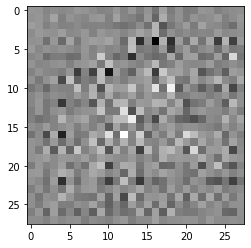

In [122]:
plt.imshow(tf.reshape(generator(np.random.rand(1,100)),(28,28)),cmap="gray")